In [19]:
# Fraud EDA Notebook
# This notebook performs exploratory data analysis on the fraud detection dataset


In [20]:
import os
from pathlib import Path

project_path = Path("../data/raw")
print("Available data files:")
print([f.name for f in project_path.glob("*.csv")])


Available data files:
['test_transaction.csv', 'train_identity.csv', 'test_identity.csv', 'train_transaction.csv']


In [21]:
import pandas as pd

train_transaction_path = project_path / "train_transaction.csv"
train_identity_path = project_path / "train_identity.csv"

train_transaction = pd.read_csv(train_transaction_path, low_memory=False)
train_identity = pd.read_csv(train_identity_path, low_memory=False)

print("train_transaction shape:", train_transaction.shape)
print("train_identity shape:", train_identity.shape)


train_transaction shape: (590540, 394)
train_identity shape: (144233, 41)


In [22]:
# Merge on TransactionID
df = train_transaction.merge(train_identity, on='TransactionID', how='left')
print("Merged dataframe shape:", df.shape)
df.head()


Merged dataframe shape: (590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [23]:
# --- Basic Cleaning ---

# 0. Rename columns for better readability
if 'id_31' in df.columns:
    df = df.rename(columns={'id_31': 'browser'})
    print("Renamed id_31 to browser")
if 'id_30' in df.columns:
    df = df.rename(columns={'id_30': 'os'})
    print("Renamed id_30 to os")

# 1. Drop any exact duplicates
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Dropped {before - after} duplicate rows")

# 2. Convert TransactionDT to datetime for time-based analysis
# This dataset uses seconds from a reference start — convert roughly to days
df['TransactionDT_days'] = df['TransactionDT'] / (24 * 60 * 60)

# 3. Check missing data %
missing = df.isnull().mean().sort_values(ascending=False)
print("Top 10 columns with missing data:")
print(missing.head(10))


Renamed id_31 to browser
Renamed id_30 to os
Dropped 0 duplicate rows
Top 10 columns with missing data:
id_24    0.991962
id_25    0.991310
id_08    0.991271
id_07    0.991271
id_21    0.991264
id_26    0.991257
id_23    0.991247
id_22    0.991247
id_27    0.991247
dist2    0.936284
dtype: float64


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plots_path = Path("../visualizations")
plots_path.mkdir(parents=True, exist_ok=True)
print(f"Plots will be saved to: {plots_path.absolute()}")


Plots will be saved to: /Users/shicky/FraudScope/notebooks/../visualizations


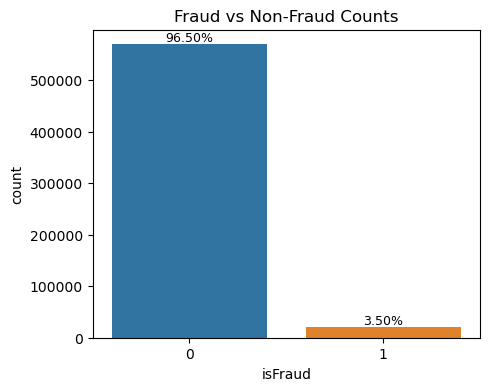

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

In [25]:
# Class imbalance plot
plt.figure(figsize=(5, 4))
ax = sns.countplot(x='isFraud', data=df)
plt.title('Fraud vs Non-Fraud Counts')

total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    perc = 100 * count / total
    ax.annotate(f'{perc:.2f}%',
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)

plt.savefig(plots_path / "fraud_class_imbalance.png",
            bbox_inches='tight')
plt.show()

df['isFraud'].value_counts(normalize=True)


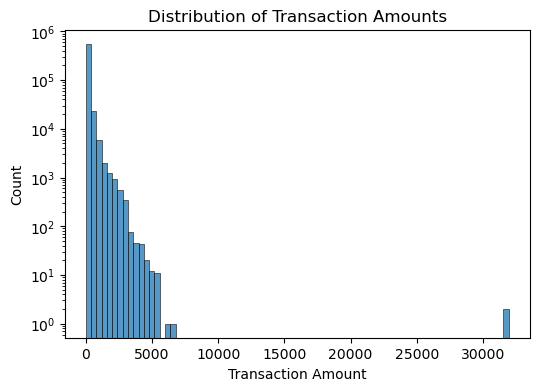

In [26]:
plt.figure(figsize=(6, 4))
sns.histplot(df['TransactionAmt'], bins=80, log_scale=(False, True))
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Distribution of Transaction Amounts')
plt.savefig(plots_path / "transaction_amount_distribution.png",
            bbox_inches='tight')
plt.show()


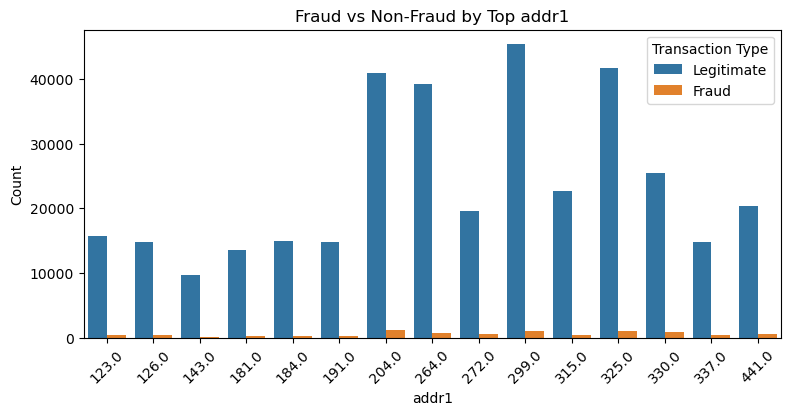

In [27]:
top_addr1 = df['addr1'].value_counts().head(15).index
subset = df[df['addr1'].isin(top_addr1)]

plt.figure(figsize=(9, 4))
sns.countplot(data=subset, x='addr1', hue='isFraud')
plt.title('Fraud vs Non-Fraud by Top addr1')
plt.xlabel('addr1')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='isFraud')
plt.savefig(plots_path / "fraud_by_addr1_top15.png",
            bbox_inches='tight')
plt.show()


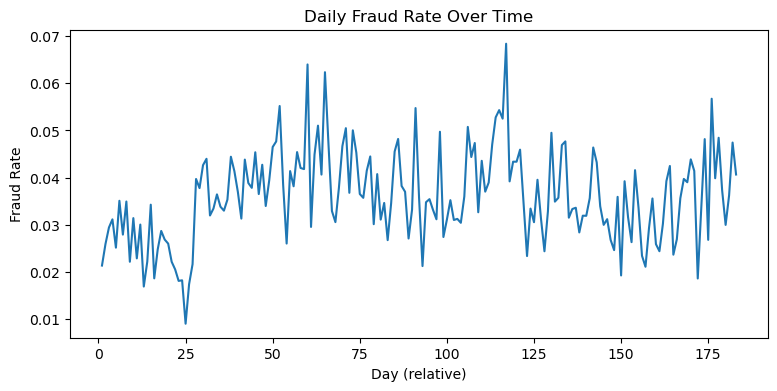

In [28]:
daily = df.groupby(df['TransactionDT_days'].round())['isFraud'] \
          .agg(['mean', 'count']).reset_index()
daily.rename(columns={'TransactionDT_days': 'day',
                      'mean': 'fraud_rate'}, inplace=True)

plt.figure(figsize=(9, 4))
sns.lineplot(data=daily, x='day', y='fraud_rate')
plt.title('Daily Fraud Rate Over Time')
plt.xlabel('Day (relative)')
plt.ylabel('Fraud Rate')
plt.savefig(plots_path / "fraud_rate_over_time.png",
            bbox_inches='tight')
plt.show()


## Device Analysis: Fraud Patterns by Device Type and Device Info


In [29]:
# Analyze fraud patterns by device type and device info
# Check if DeviceType and DeviceInfo columns exist
if 'DeviceType' in df.columns and 'DeviceInfo' in df.columns:
    print("=" * 80)
    print("DEVICE ANALYSIS: Fraud Patterns by Device Type and Device Info")
    print("=" * 80)
    
    # 1. DeviceType Analysis
    print("\n1. Fraud Rate by DeviceType:")
    print("-" * 80)
    device_type_analysis = df.groupby('DeviceType')['isFraud'].agg(['mean', 'count']).round(4)
    device_type_analysis.columns = ['Fraud_Rate', 'Transaction_Count']
    device_type_analysis['Fraud_Rate_Percent'] = (device_type_analysis['Fraud_Rate'] * 100).round(2)
    print(device_type_analysis)
    
    # Calculate relative risk
    overall_fraud_rate = df['isFraud'].mean()
    device_type_analysis['Relative_Risk'] = (device_type_analysis['Fraud_Rate'] / overall_fraud_rate).round(2)
    print(f"\nOverall fraud rate: {overall_fraud_rate:.4f} ({overall_fraud_rate*100:.2f}%)")
    print("\nRelative Risk (compared to overall rate):")
    print(device_type_analysis[['Relative_Risk']])
    
    # 2. DeviceInfo Analysis - Top devices by fraud rate
    print("\n\n2. Top 20 DeviceInfo by Fraud Rate (minimum 10 transactions):")
    print("-" * 80)
    device_info_analysis = df.groupby('DeviceInfo')['isFraud'].agg(['mean', 'count']).round(4)
    device_info_analysis.columns = ['Fraud_Rate', 'Transaction_Count']
    device_info_analysis = device_info_analysis[device_info_analysis['Transaction_Count'] >= 10]
    device_info_analysis = device_info_analysis.sort_values('Fraud_Rate', ascending=False)
    device_info_analysis['Fraud_Rate_Percent'] = (device_info_analysis['Fraud_Rate'] * 100).round(2)
    print(device_info_analysis.head(20))
    
    # 3. DeviceInfo Analysis - Most common devices
    print("\n\n3. Top 20 Most Common DeviceInfo:")
    print("-" * 80)
    device_info_common = df['DeviceInfo'].value_counts().head(20)
    device_info_common_fraud = df.groupby('DeviceInfo')['isFraud'].mean().loc[device_info_common.index]
    device_info_common_df = pd.DataFrame({
        'Transaction_Count': device_info_common,
        'Fraud_Rate': device_info_common_fraud,
        'Fraud_Rate_Percent': (device_info_common_fraud * 100).round(2)
    })
    print(device_info_common_df)
    
    # 4. Summary Statistics
    print("\n\n4. Summary Statistics:")
    print("-" * 80)
    print(f"Total unique DeviceInfo values: {df['DeviceInfo'].nunique()}")
    print(f"DeviceInfo missing values: {df['DeviceInfo'].isnull().sum()} ({df['DeviceInfo'].isnull().mean()*100:.2f}%)")
    print(f"DeviceType missing values: {df['DeviceType'].isnull().sum()} ({df['DeviceType'].isnull().mean()*100:.2f}%)")
    
else:
    print("DeviceType or DeviceInfo columns not found in the dataset.")


DEVICE ANALYSIS: Fraud Patterns by Device Type and Device Info

1. Fraud Rate by DeviceType:
--------------------------------------------------------------------------------
            Fraud_Rate  Transaction_Count  Fraud_Rate_Percent
DeviceType                                                   
desktop         0.0652              85165                6.52
mobile          0.1017              55645               10.17

Overall fraud rate: 0.0350 (3.50%)

Relative Risk (compared to overall rate):
            Relative_Risk
DeviceType               
desktop              1.86
mobile               2.91


2. Top 20 DeviceInfo by Fraud Rate (minimum 10 transactions):
--------------------------------------------------------------------------------
                                     Fraud_Rate  Transaction_Count  \
DeviceInfo                                                           
Blade L3 Build/KOT49H                    1.0000                 12   
NOKIA                                   

Device analysis plots saved to '../visualizations/fraud_by_device_analysis.png'


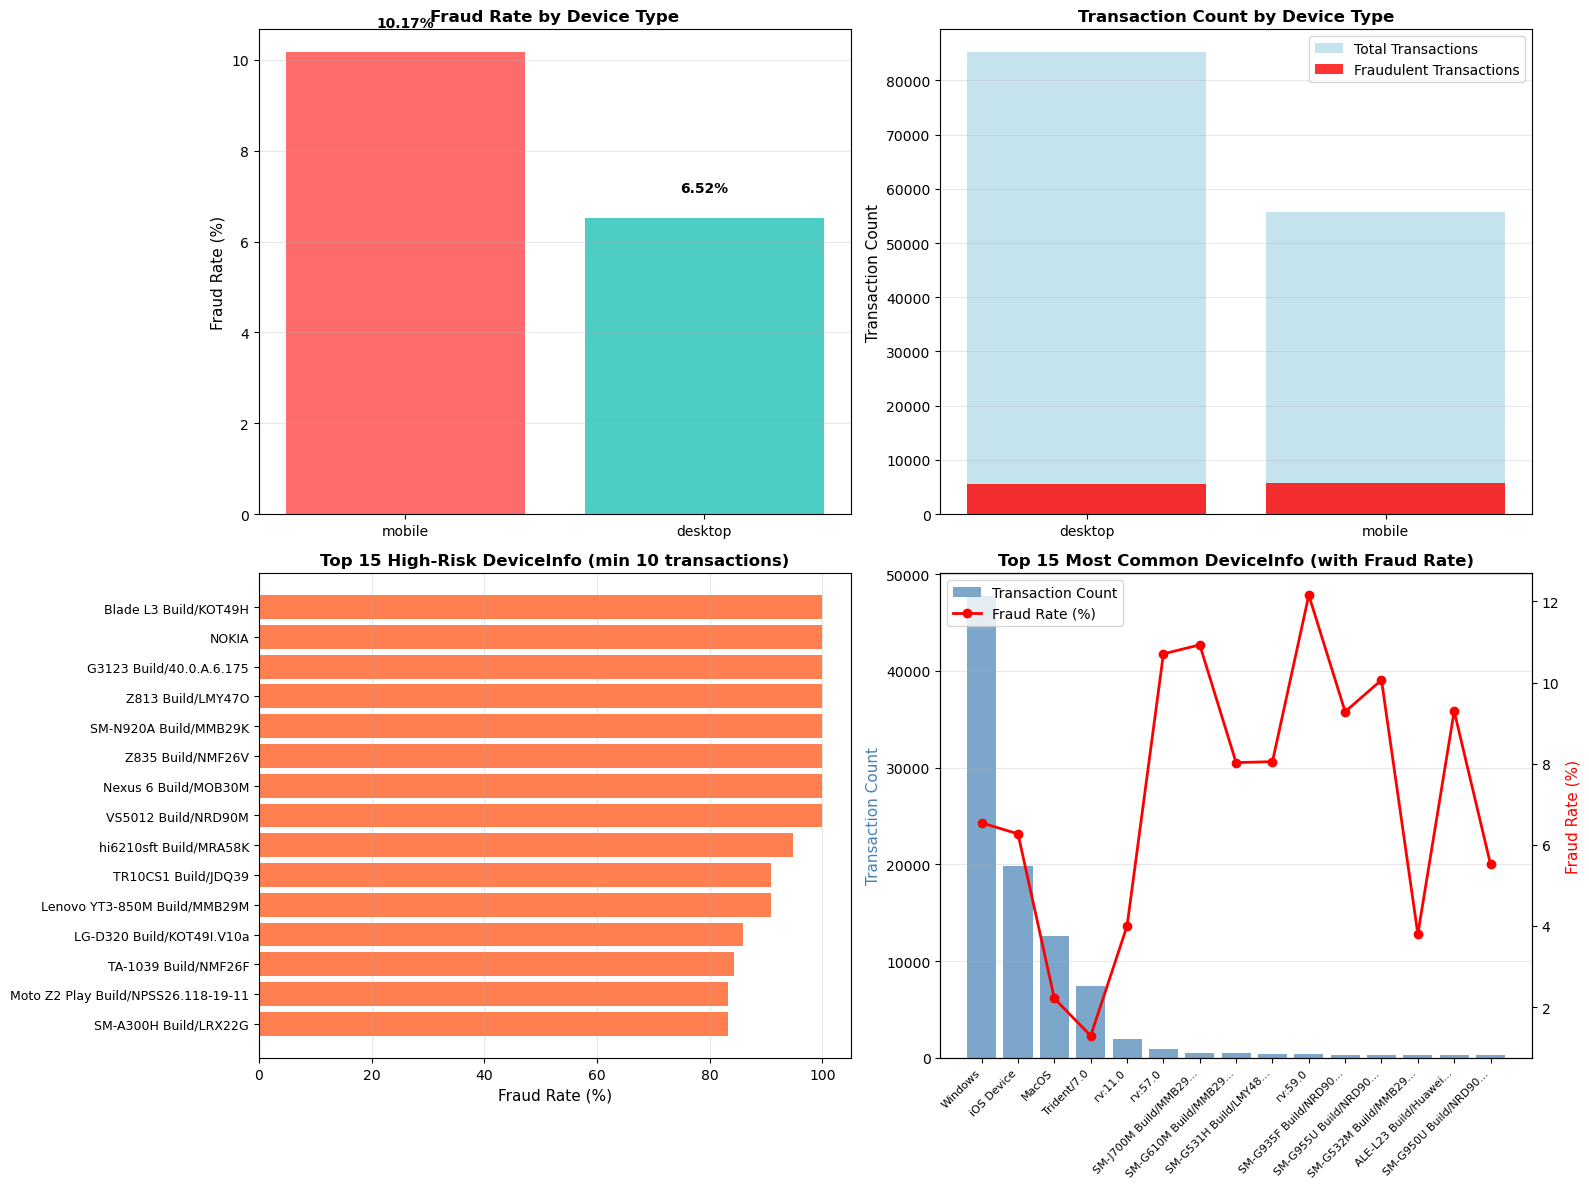


KEY INSIGHTS:
1. Mobile devices have 1.56x higher fraud rate than desktop devices
   - Mobile: 10.17% fraud rate
   - Desktop: 6.52% fraud rate

2. Highest risk device: 'Blade L3 Build/KOT49H'
   - Fraud rate: 100.00%
   - Transaction count: 12

3. DeviceInfo has 1786 unique values
   - High cardinality feature (creates many one-hot encoded columns)
   - Consider feature engineering: extract OS, brand, or group rare devices

4. Recommendation: Keep both DeviceType and DeviceInfo in the model
   - DeviceType: Strong signal, low cardinality, easy to interpret
   - DeviceInfo: Provides granular insights, already in top 20 features


In [30]:
# Visualizations for Device Analysis
if 'DeviceType' in df.columns and 'DeviceInfo' in df.columns:
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Fraud Rate by DeviceType (Bar Chart)
    device_type_fraud = df.groupby('DeviceType')['isFraud'].mean().sort_values(ascending=False)
    axes[0, 0].bar(device_type_fraud.index, device_type_fraud.values * 100, color=['#ff6b6b', '#4ecdc4'])
    axes[0, 0].set_ylabel('Fraud Rate (%)', fontsize=11)
    axes[0, 0].set_title('Fraud Rate by Device Type', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    # Add value labels
    for i, (device, rate) in enumerate(device_type_fraud.items()):
        axes[0, 0].text(i, rate * 100 + 0.5, f'{rate*100:.2f}%', 
                       ha='center', va='bottom', fontweight='bold')
    
    # 2. Transaction Count by DeviceType (with fraud overlay)
    device_type_counts = df['DeviceType'].value_counts()
    device_type_fraud_counts = df[df['isFraud'] == 1]['DeviceType'].value_counts()
    x_pos = range(len(device_type_counts))
    axes[0, 1].bar(x_pos, device_type_counts.values, label='Total Transactions', color='lightblue', alpha=0.7)
    axes[0, 1].bar(x_pos, device_type_fraud_counts.reindex(device_type_counts.index, fill_value=0).values, 
                   label='Fraudulent Transactions', color='red', alpha=0.8)
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(device_type_counts.index)
    axes[0, 1].set_ylabel('Transaction Count', fontsize=11)
    axes[0, 1].set_title('Transaction Count by Device Type', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. Top 15 High-Risk DeviceInfo (by fraud rate, min 10 transactions)
    device_info_high_risk = df.groupby('DeviceInfo')['isFraud'].agg(['mean', 'count'])
    device_info_high_risk = device_info_high_risk[device_info_high_risk['count'] >= 10]
    device_info_high_risk = device_info_high_risk.sort_values('mean', ascending=False).head(15)
    
    axes[1, 0].barh(range(len(device_info_high_risk)), device_info_high_risk['mean'].values * 100, 
                     color='coral')
    axes[1, 0].set_yticks(range(len(device_info_high_risk)))
    # Truncate long device names for readability
    device_names = [name[:40] + '...' if len(name) > 40 else name for name in device_info_high_risk.index]
    axes[1, 0].set_yticklabels(device_names, fontsize=9)
    axes[1, 0].set_xlabel('Fraud Rate (%)', fontsize=11)
    axes[1, 0].set_title('Top 15 High-Risk DeviceInfo (min 10 transactions)', fontsize=12, fontweight='bold')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(True, alpha=0.3, axis='x')
    
    # 4. Top 15 Most Common DeviceInfo (with fraud rate)
    device_info_common = df['DeviceInfo'].value_counts().head(15)
    device_info_common_fraud = df.groupby('DeviceInfo')['isFraud'].mean().loc[device_info_common.index]
    
    x_pos = range(len(device_info_common))
    ax2_twin = axes[1, 1].twinx()
    bars = axes[1, 1].bar(x_pos, device_info_common.values, color='steelblue', alpha=0.7, label='Transaction Count')
    line = ax2_twin.plot(x_pos, device_info_common_fraud.values * 100, 
                        color='red', marker='o', linewidth=2, markersize=6, label='Fraud Rate (%)')
    
    axes[1, 1].set_xticks(x_pos)
    device_names_common = [name[:20] + '...' if len(name) > 20 else name for name in device_info_common.index]
    axes[1, 1].set_xticklabels(device_names_common, rotation=45, ha='right', fontsize=8)
    axes[1, 1].set_ylabel('Transaction Count', fontsize=11, color='steelblue')
    ax2_twin.set_ylabel('Fraud Rate (%)', fontsize=11, color='red')
    axes[1, 1].set_title('Top 15 Most Common DeviceInfo (with Fraud Rate)', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add legend
    lines1, labels1 = axes[1, 1].get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    axes[1, 1].legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.tight_layout()
    plt.savefig(plots_path / "fraud_by_device_analysis.png", dpi=300, bbox_inches='tight')
    print("Device analysis plots saved to '../visualizations/fraud_by_device_analysis.png'")
    plt.show()
    
    # Key Insights
    print("\n" + "=" * 80)
    print("KEY INSIGHTS:")
    print("=" * 80)
    mobile_fraud_rate = df[df['DeviceType'] == 'mobile']['isFraud'].mean() if 'mobile' in df['DeviceType'].values else 0
    desktop_fraud_rate = df[df['DeviceType'] == 'desktop']['isFraud'].mean() if 'desktop' in df['DeviceType'].values else 0
    
    if mobile_fraud_rate > 0 and desktop_fraud_rate > 0:
        risk_ratio = mobile_fraud_rate / desktop_fraud_rate
        print(f"1. Mobile devices have {risk_ratio:.2f}x higher fraud rate than desktop devices")
        print(f"   - Mobile: {mobile_fraud_rate*100:.2f}% fraud rate")
        print(f"   - Desktop: {desktop_fraud_rate*100:.2f}% fraud rate")
    
    if len(device_info_high_risk) > 0:
        highest_risk_device = device_info_high_risk.index[0]
        highest_risk_rate = device_info_high_risk.iloc[0]['mean']
        print(f"\n2. Highest risk device: '{highest_risk_device[:50]}'")
        print(f"   - Fraud rate: {highest_risk_rate*100:.2f}%")
        print(f"   - Transaction count: {int(device_info_high_risk.iloc[0]['count'])}")
    
    print(f"\n3. DeviceInfo has {df['DeviceInfo'].nunique()} unique values")
    print("   - High cardinality feature (creates many one-hot encoded columns)")
    print("   - Consider feature engineering: extract OS, brand, or group rare devices")
    
    print("\n4. Recommendation: Keep both DeviceType and DeviceInfo in the model")
    print("   - DeviceType: Strong signal, low cardinality, easy to interpret")
    print("   - DeviceInfo: Provides granular insights, already in top 20 features")
else:
    print("DeviceType or DeviceInfo columns not found. Skipping visualizations.")


In [ ]:
clean_path = Path("../data/processed/clean_train.parquet")
clean_path.parent.mkdir(parents=True, exist_ok=True)
df.to_parquet(clean_path, index=False)
print(f"Cleaned data saved to: {clean_path}")


Cleaned data saved to: ../data/processed/clean_train.parquet


: 